<h1 align=center><font size=6>Data Bootcamp</font></h1>
<h2 align=center><font size=6>Fall 2021</font></h2>
<h2 align=center><font size=6>Assignment 4</font></h2>

<hr>

<h2 align = "center">Names and NetIDs: </h2>
<h3 align = "center"> Names: Brandon Gao, Siegrid Tuttle, Michael Xu </h3>
<h3 align = "center"> NetIDs: bsg9679, sgt2559, tx542 </h3>

In [1]:
# NOTE: be sure to run the import statements first, before anything else... 
# import the relevant libraries 
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

from plotnine import *
import plotnine
# set the plotnine figure size
plotnine.options.figure_size = (8, 6)
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# data imbalance
from sklearn.utils import resample

# filter out unnecessary warnings... 
import warnings
warnings.filterwarnings('ignore')

### Question 1:

The small imaginary country of Rarotonga is really interested in becoming the largest possible exporter of their national fruit, **the girostopo**. The girostopo is a fruit that needs to be harvested delicately and requires special tooling. There are **two types of tools** that are in short supply and **one is made fully of aluminum**, and **the other one has golden tips**. In order to prevent the tools with golden tips from running out, the government indicates that **only those who achieve a score of 766 or higher out of 800 in a national fruit picking test can purchase the golden tip ones**. Some people rumor that the golden tips don't actually make any difference. Using the data from:

https://drive.google.com/file/d/1OEphiqW4VlpuAuz1QTtemCSZkzOFfg8x/view?usp=sharing

**Establish if the tools actually generate a greater yield**, and be sure to answer the following questions:

- How do we know if it's just the tools and not the level of ability measured by the test?
- What technique are you using and why?
- How is this different from an experiment?
- Can you check if the difference in tools actually creates different yields if you made different assumptions about the shape of the relationship you think yield and score have?

Let us start by loading the dataset and taking a look at some descriptive statistics, as usual:

In [2]:
df_q1 = pd.read_csv("rdd_rarotonga.csv")
df_q1.head(20)

,yield,score
0,143.458137,765.963832
1,210.550664,767.953965
2,141.786601,764.862454
3,192.392737,765.292672
4,182.075053,764.681314
5,183.196058,765.796140
6,213.377662,766.774738
7,186.037803,767.180279
8,117.152859,764.630958
9,167.326372,764.083400


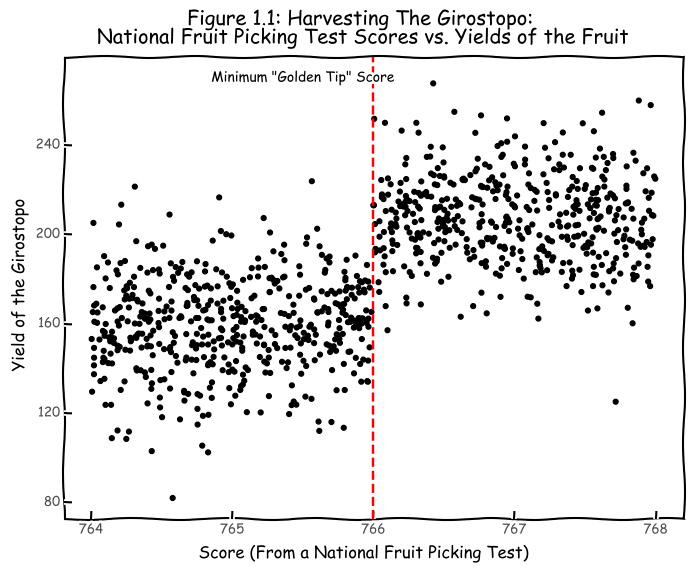

<ggplot: (305539042)>

In [3]:
(ggplot(data = df_q1, mapping = aes(x = 'score', y = 'yield'))
 + geom_point()
 + geom_vline(xintercept = 766, color = 'red', size = 1, linetype = 'dashed')
 + annotate("text", x = 765.5, y = 270, label = 'Minimum "Golden Tip" Score', size = 10)
 + labs(y = 'Yield of the Girostopo',
        x = 'Score (From a National Fruit Picking Test)')
 + ggtitle('Figure 1.1: Harvesting The Girostopo: \nNational Fruit Picking Test Scores vs. Yields of the Fruit')
 + theme_xkcd())

# of course, for fun and with a comical spirit, we use the `xkcd` theme!


In [4]:
df_q1.describe()

,yield,score
count,1000.000000,1000.000000
mean,182.508116,765.957434
std,31.073279,1.162437
min,81.935743,764.005059
25%,159.092590,764.921966
50%,182.946516,765.936709
75%,206.414783,766.948569
max,267.592531,767.998604


#### How do we know if it's just the tools and not the level of ability measured by the test?

As illustrated above in both Figure 1 and the DataFrame description table, we can easily discern that scores of all recorded individual observations are **very close to the threshold of 766, which is the minimum score necessary for the purchase of the harvesting tool with golden tips**. 

This proximity to the threshold suggests that individual observations on both sides of the threshold **should be comparable in all other aspects except for which tool they are using**, thus controlling for the classic *ceteris paribus - everything else being/remaining the same* assumption. We are thus confident that the only differentiating factor (*treatment effect*) would be the **tool used (fully aluminum or with golden tips)**. This is also known as the Local Average Treatment Effect (LATE). 


#### What technique are you using and why?

We will be using the **Regression Discontinuity Design (RDD)** technique. As requested by this question and also discussed above, we want to establish whether **the "treatment"** (i.e. **being allowed to purchase the tool with golden tips**, rather than only allowed to purchase the regular, fully aluminum tool) has a **causal relationship** on the yield of the *girostopo* fruit (likely an increase in the yield). 

And further considering that we cannot randomly experiment with this hallmark agricultural sector of the entire country of Rarotonga as we would in a controlled laboratory environment, we can only **control for other contributing factors to the yield** of the fruit by focusing our analysis on samples that are **really close to the threshold (from both directions), which should be very similar and comparable to each other**. This is the intuition behind the Regression Discontinuity Design (RDD) technique.

#### How is this different from an experiment?

In controlled experiments, we would randomly select samples, and randomly decide which individuals would be in the control vs. treated group. This process of **randomization** can get rid of the *selection bias*, which can happen if treatment assignment is not conducted randomly, but rather as an outcome of factors exogenous to the model. This *selection bias* would make the control vs. treated groups no longer comparable in all other aspects, thereby **confounding** our investigation of the causal relations between the treatment and the outcome. 

Nonetheless, though in the real world—either out of pragmatic and/or ethical concerns—we cannot always conduct random assignments in controlled experiments, we can use **quasi-experimental techniques** such as the **Regression Discontinuity Design (RDD)** technique to establish/identify sufficiently comparable groups *(by their proximity to the threshold, in the case of RDD)*, thereby minimizing the influences of selection biases. 

#### Proceeding with Regression Discontinuity Design (RDD) experimentations

Let us proceed with our Regression Discontinuity Design (RDD) experimentations. The first step would be to create the `treatment` dummy variable to account for which group (control vs. treated) each individual observation would belong to. We will also center the running variable (the `score` from the National Fruit Picking Test) for better regression results. 

We will also include a cross (interaction) term to allow for different slopes and intercepts (thus different relationships between `yield` and `score`) for the control vs. treated groups.

In [5]:
# treatment assignment: 1 for treated group; 0 for control group
df_q1['treatment'] = np.where(df_q1['score'] >= 766, 1, 0) 

# also: centering the running variable (score)
# to make the regression result more readable
df_q1['ctr_score'] = df_q1['score'] - 766 

# construct the cross (interaction) term
df_q1['interact'] = df_q1['treatment'] * df_q1['ctr_score']

Our OLS regression model is:
$$yield =\alpha+\beta ctr\_score+\delta treatment+\gamma ctr\_score*treatment+\varepsilon$$

*Comment: In our experiments, we have found that the variable name `yield` would cause a `PatsyError: Error evaluating factor: SyntaxError: unexpected EOF while parsing (<string>, line 1)` error in the `smf.ols` method. So we will just simply rename our y-variable:*

In [6]:
df_q1.rename(columns = {"yield": "fr_yield"}, inplace = True)

In [7]:
reg_1 = smf.ols('fr_yield ~ ctr_score + treatment + interact', df_q1).fit()

reg_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               fr_yield   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     483.9
Date:                Tue, 30 Nov 2021   Prob (F-statistic):          6.78e-194
Time:                        15:40:03   Log-Likelihood:                -4405.2
No. Observations:                1000   AIC:                             8818.
Df Residuals:                     996   BIC:                             8838.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    161.7757      1.780     90.902      0.000     158.283     165.268
ctr_score      2.4406      1.514      1.612      0.107      -0.530       5.412
treatment     46.6962      2.531     18.451      0.000      41.730      51.662
interact      -3.8434      2.178     -1.764      0.078      -8.118       0.431
==============================================================================
Omnibus:                        7.060   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.029   Jarque-Bera (JB):                9.174
Skew:                          -0.054   Prob(JB):                       0.0102
Kurtosis:                       3.457   Cond. No.                         7.65
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As illustrated above in the regression table, the estimated coefficient for `treatment` ($\hat{\delta}$) is **statistically significant at the 5% significance level** (by either the p-value or the confidence interval), which provides sufficient evidence to support the claim that $\delta$ is **different from zero** at the 5% significance level. This also suggests that those belonging to the treated group have **a higher intercept** than those belonging to the control group. **This would be the treatment effect (of having the golden tip tools).**

On the other hand, the estimated coefficient for the interaction term `ctr_score*treatment` ($\hat{\gamma }$) is **not** statistically significant at the 5% significance level (by either the p-value or the confidence interval), which suggests that we **cannot reject the claim that $\gamma$ is not different from zero** at the 5% significance level. This also suggests that the treated group and the control group have **the same slope** in terms of the relationship between `yield` and `score`. 

See Figure 2 below for a graphic illustration for the two different OLS regression lines for the control vs. treated group:

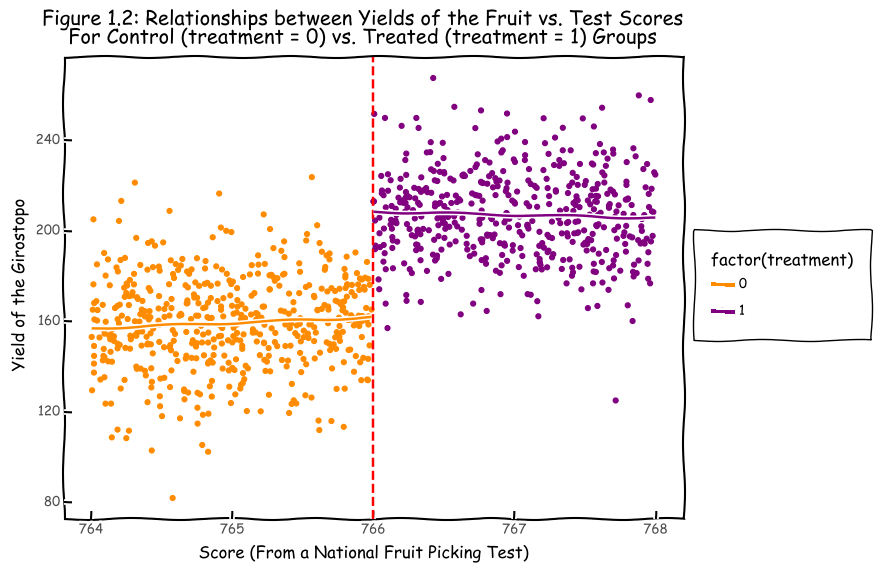

<ggplot: (305913784)>

In [8]:
(ggplot(data = df_q1, mapping = aes(x = 'score', y = 'fr_yield', color = 'factor(treatment)'))
 + geom_point()
 + geom_vline(xintercept = 766, color = 'red', size = 1, linetype = 'dashed')
 + scale_color_manual(values = ['darkorange', 'purple'])
 + geom_smooth(method = 'ols', formula = 'y ~ x', size = 1, se = False)
 + labs(y = 'Yield of the Girostopo',
        x = 'Score (From a National Fruit Picking Test)')
 + ggtitle('Figure 1.2: Relationships between Yields of the Fruit vs. Test Scores\nFor Control (treatment = 0) vs. Treated (treatment = 1) Groups')
 + theme_xkcd())

#### Can you check if the difference in tools actually creates different yields if you made different assumptions about the shape of the relationship you think yield and score have?

Let us proceed with our experimentations by allowing **nonlinearity** in the OLS regression model, such as the one below:

$$yield =\alpha+\beta_1 ctr\_score+\beta_2 ctr\_score^2+
\delta treatment+\gamma_1 ctr\_score*treatment+\gamma_2 ctr\_score^2*treatment+\varepsilon$$

In [9]:
# squared score term
df_q1['ctr_score_sq'] = df_q1['ctr_score'] ** 2

# squared interact term
df_q1['interact_sq'] = df_q1['ctr_score_sq'] * df_q1['treatment']

In [10]:
reg_2 = smf.ols('fr_yield ~ ctr_score + ctr_score_sq + treatment + interact + interact_sq', df_q1).fit()

reg_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               fr_yield   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     290.8
Date:                Tue, 30 Nov 2021   Prob (F-statistic):          1.07e-191
Time:                        15:40:04   Log-Likelihood:                -4404.1
No. Observations:                1000   AIC:                             8820.
Df Residuals:                     994   BIC:                             8850.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      163.5071      2.628     62.213      0.000     158.350     168.665
ctr_score        7.6651      6.029      1.271      0.204      -4.167      19.497
ctr_score_sq     2.6163      2.923      0.895      0.371      -3.119       8.352
treatment       42.5321      3.769     11.283      0.000      35.135      49.929
interact        -1.6682      8.742     -0.191      0.849     -18.822      15.486
interact_sq     -6.3494      4.256     -1.492      0.136     -14.701       2.002
==============================================================================
Omnibus:                        6.947   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.031   Jarque-Bera (JB):                9.087
Skew:                          -0.045   Prob(JB):                       0.0106
Kurtosis:                       3.458   Cond. No.                         39.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As illustrated above in the regression table, we can clearly see that **the only statistically significant estimated coefficient (at the 5% significance level, apart from the intercept), is that for `treatment` ($\hat{\delta}$)**. This suggests that we cannot reject the claim that the relationships between `yield` and `score` **are linear for both control and treated groups (with the same slope)**, and that **the treatment effect (of having the golden tip tools)** would be the statistically significant **higher intercept** in the relationship between `yield` and `score` for **the treated group**, than that for the control group.

See Figure 3 below for a graphic illustration of the relationships between `yield` and `score` for both groups, where the assumptions are relaxed so that nonlinearity is permitted in the relationships. 

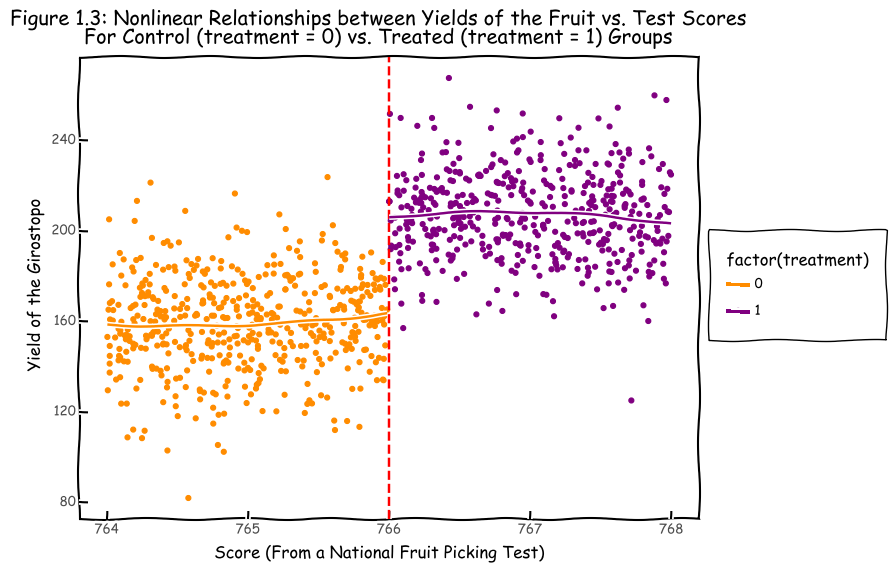

<ggplot: (274948343)>

In [11]:
(ggplot(data = df_q1, mapping = aes(x = 'score', y = 'fr_yield', color = 'factor(treatment)'))
 + geom_point()
 + geom_vline(xintercept = 766, color = 'red', size = 1, linetype = 'dashed')
 + scale_color_manual(values = ['darkorange', 'purple'])
 + geom_smooth(method = 'ols', formula = 'y ~ x+I(x**2)', se = False)
 + labs(y = 'Yield of the Girostopo',
        x = 'Score (From a National Fruit Picking Test)')
 + ggtitle('Figure 1.3: Nonlinear Relationships between Yields of the Fruit vs. Test Scores\nFor Control (treatment = 0) vs. Treated (treatment = 1) Groups')
 + theme_xkcd())

### Question 2

Make the final selection of the dataset you want to use for your final project. Outline the following:

- What questions do you want to answer with this data?
- What is your plan for exploration (and/or preliminary observations)?
- What techniques are you thinking to use to test your hypothesis?
- What possible limitations do you expect to face, and how would you justify them?

### **Final Project Dataset: <a href = "https://www.kaggle.com/aljarah/xAPI-Edu-Data">Students' Academic Performance Dataset</a> (from Kaggle)**
- URL: https://www.kaggle.com/aljarah/xAPI-Edu-Data

### 2.1: Some Questions We Want to Answer with This Data & Potential Corresponding Techniques
Addressing **sub-questions 1 and 3**:
- What questions do you want to answer with this data? 
- What techniques are you thinking to use to test your hypothesis?)

As usual, before anything else, let us start by loading the dataset and taking a look at some descriptive statistics:

In [12]:
df_final = pd.read_csv("xAPI-Edu-Data.csv")
df_final.head(20)

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,15,16,2,20,Yes,Good,Under-7,M
1,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,20,20,3,25,Yes,Good,Under-7,M
2,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,10,7,0,30,No,Bad,Above-7,L
3,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,30,25,5,35,No,Bad,Above-7,L
4,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,40,50,12,50,No,Bad,Above-7,M
5,F,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,42,30,13,70,Yes,Bad,Above-7,M
6,M,KW,KuwaIT,MiddleSchool,G-07,A,Math,F,Father,35,12,0,17,No,Bad,Above-7,L
7,M,KW,KuwaIT,MiddleSchool,G-07,A,Math,F,Father,50,10,15,22,Yes,Good,Under-7,M
8,F,KW,KuwaIT,MiddleSchool,G-07,A,Math,F,Father,12,21,16,50,Yes,Good,Under-7,M
9,F,KW,KuwaIT,MiddleSchool,G-07,B,IT,F,Father,70,80,25,70,Yes,Good,Under-7,M


In [13]:
df_final.dtypes

gender                      object
NationalITy                 object
PlaceofBirth                object
StageID                     object
GradeID                     object
SectionID                   object
Topic                       object
Semester                    object
Relation                    object
raisedhands                  int64
VisITedResources             int64
AnnouncementsView            int64
Discussion                   int64
ParentAnsweringSurvey       object
ParentschoolSatisfaction    object
StudentAbsenceDays          object
Class                       object
dtype: object

Many variables that should be categorical data (because the set of unique values is finite and artificially constructed this way, as suggested by descriptions of the dataset on https://www.kaggle.com/aljarah/xAPI-Edu-Data) are read as `object` by the Pandas library. Let us make those variables `Pandas.Categorical`, as they should be:

In [14]:
# make each categorical variable a Pandas Categorical,
# using their respective list of ordered categories

cate_var_ls = ["gender", "NationalITy", "PlaceofBirth", "StageID",
              "GradeID", "SectionID", "Topic", "Semester", "Relation",
              "ParentAnsweringSurvey", "ParentschoolSatisfaction",
              "StudentAbsenceDays", "Class"]

for col_label in cate_var_ls:
    df_final[col_label] = pd.Categorical(df_final[col_label],
    categories = list(df_final[col_label].value_counts().index),
    ordered = True)

In [15]:
df_final.dtypes

gender                      category
NationalITy                 category
PlaceofBirth                category
StageID                     category
GradeID                     category
SectionID                   category
Topic                       category
Semester                    category
Relation                    category
raisedhands                    int64
VisITedResources               int64
AnnouncementsView              int64
Discussion                     int64
ParentAnsweringSurvey       category
ParentschoolSatisfaction    category
StudentAbsenceDays          category
Class                       category
dtype: object

In [16]:
df_final.describe(include = [np.number, "category"])

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
count,480,480,480,480,480,480,480,480,480,480.000000,480.000000,480.000000,480.000000,480,480,480,480
unique,2,14,14,3,10,3,12,2,2,NaN,NaN,NaN,NaN,2,2,2,3
top,M,KW,KuwaIT,MiddleSchool,G-02,A,IT,F,Father,NaN,NaN,NaN,NaN,Yes,Good,Under-7,M
freq,305,179,180,248,147,283,95,245,283,NaN,NaN,NaN,NaN,270,292,289,211
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.775000,54.797917,37.918750,43.283333,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.779223,33.080007,26.611244,27.637735,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,1.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.750000,20.000000,14.000000,20.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.000000,65.000000,33.000000,39.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.000000,84.000000,58.000000,70.000000,NaN,NaN,NaN,NaN


While many studies address the effect of demographics and income level on educational outcomes, we would like to also examine how **students’ behavioral and micro-systemic traits** (i.e. explanatory factors such as **parental interest in school, how much students participate in class, and how often they raise their hand**) are associated or correlated with their **academic performance and attendance**. We also hope to establish **predictive and causative models** that can estimate the outcome (academic performance and/or attendance) given combinations of the aforementioned explanatory variables. 

To this end, we found a dataset collected through *Kalboard 360*, a learning management system (LMS) that keeps track of students' behaviors on a micro-level, allowing us to analyze factors affecting student academic performance that would have been very difficult to track before the implementation of such learning management systems. The results of this inquiry will hopefully shed light on what factors are important to student success and what behaviors may indicate whether a student is "struggling". 

We plan to address the **following topics and related questions**, using the **respective techniques/methods listed right under them**:

1. Our first group of questions focuses on using **descriptive information to describe factors affecting student’s experience in school**:
- What topics do students perform the worst in academically, and what topics do they have the lowest attendance for? 
- What factors affect girls’ access to education? Do nationality, topic, or grade predict how equal the male to female ratio is in the dataset? 

We already graphed student performance in different subjects using multi-indices and stacking (see **Figure 2.4 below**). We plan to use graphical visualizations (`ggplot` or `df.plot()`) to display differences in student performance, student attendance, and the gender ratio based on different factors.


2. Our second set of questions in based on **predicting student outcomes based on different factors**:
- Can a student’s performance and attendance be predicted by their demographics, academic background, behavior, and/or immediate micro-system (i.e. parents/family)? 
- Which of these features is most highly correlated with students’ academic performance? 
- Which of these features is most highly correlated with students’ absences?
- Does participation affect students’ academic performance? (i.e. Is a quiet student just shy, or is this a good indicator that they are struggling academically?)

For these questions, we plan to use **classification prediction models** and use **cross-validation and train-test-split to identify the best models (i.e. optimal hyperparameter, optimal C-V and train-test scores)** to predict student performance. We plan to use the cross-validation score as a comparison standard. In certain cases, we may supplement our predictive models with OLS significance tests (such as T-test or F joint significance test). 

3. Our final question addresses the **gender-performance gap** we noticed in our initial data exploration (see more details below):
- Is there a statistically significant gender gap in educational outcomes?

For this question, we plan to use OLS regression, including the gender dummy variable to allow for different slopes and intercepts for the two binary categories of gender (as given in this dataset).

### 2.2: Some Preliminary Descriptive Explorations & Observations
Addressing **sub-questions 2**:
- What is your plan for exploration (and/or preliminary observations)?

Let us firstly take a look at the distributions/percentage-components of our continuous and categorical variables:

In [17]:
def make_hist(var_x_label, df):
    '''
    A function that can make a histogram, overlaid with KDE 
    estimation line, for the given column label (corresponding 
    to a column variable) of the given DataFrame.
    '''
    obj = (ggplot(df.dropna(subset = [var_x_label]), aes(x = var_x_label)) 
           + geom_histogram(aes(y = "stat(density)"), alpha = 0.5, fill = "green")
           + geom_density(color = "red", alpha = 0.5)
           + ggtitle('Histogram for the Density Distribution of "{}" with KDE Line'\
                     .format(var_x_label))
           + ylab("Density")
           + xlab(var_x_label)
           + theme_bw())
    
    return obj

In [18]:
def plot_pie(var_name, df, custom_colors = None):
    '''
    A function that can make a pie chart for the given column label 
    (corresponding to a column variable) of the given DataFrame
    '''
    plt.clf() # clear any previous figure window
    plt.figure(figsize = (8, 6), dpi = 100) # set figure size
    plt.pie(df[var_name].value_counts(), 
            labels = df[var_name].value_counts().index,
            autopct = '%.2f%%', # customized colors below:
            colors = ["red", "blue", "orange", "green", "lightskyblue", "gold"],
            wedgeprops = {"alpha": 0.4}) # increase transparency for visual effects
    plt.title('Pie Chart of "{}"'.format(var_name))
    plt.axis('equal')
    return plt

In [19]:
for num_col_label in ["raisedhands", "VisITedResources",
                     "AnnouncementsView", "Discussion"]:
    make_hist(num_col_label, df_final).save("histograms/hist_{}.png".format(num_col_label))

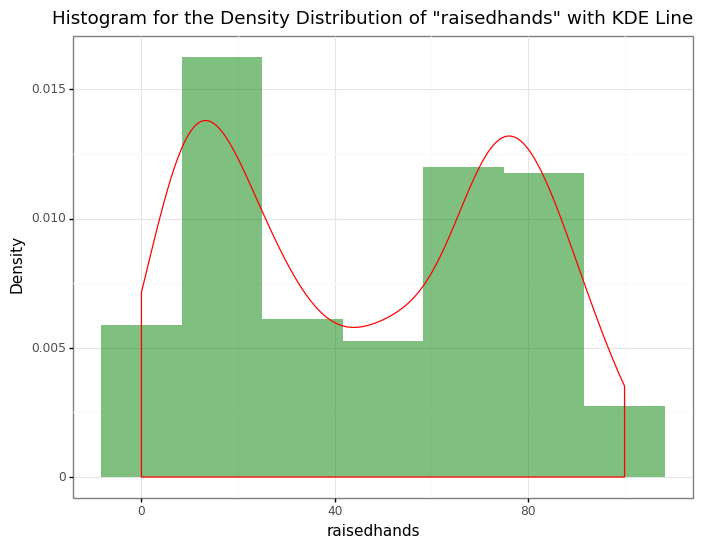

<ggplot: (306270160)>

In [20]:
make_hist("raisedhands", df_final)

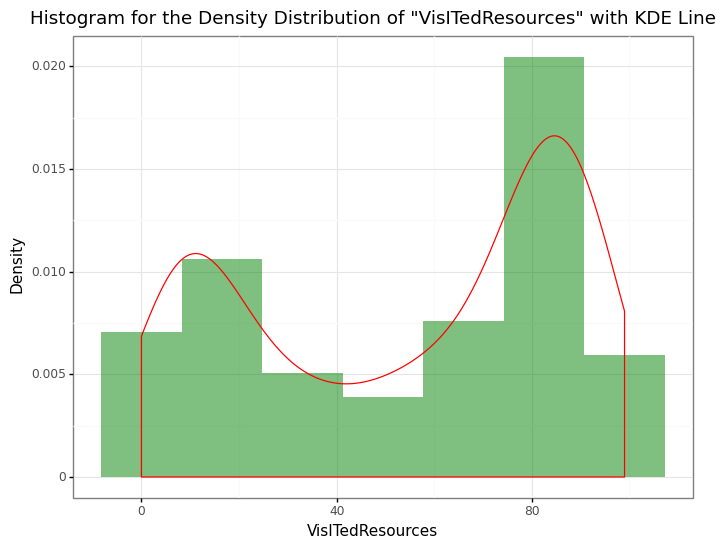

<ggplot: (305780496)>

In [21]:
make_hist("VisITedResources", df_final)

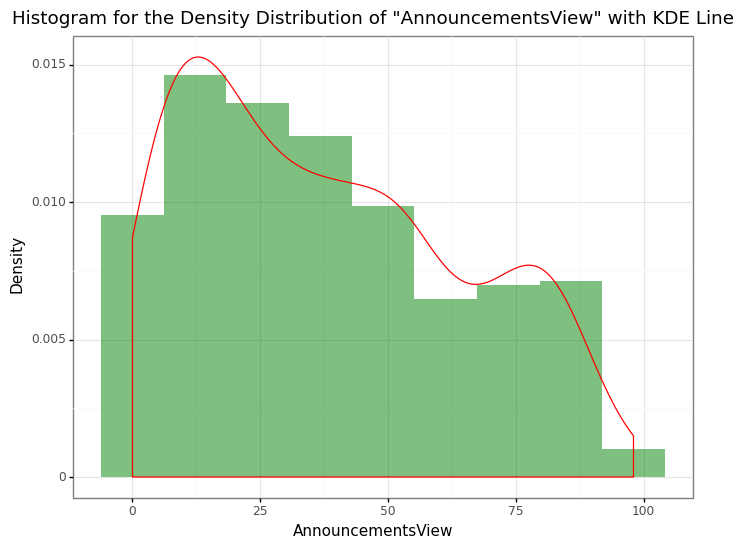

<ggplot: (306511186)>

In [22]:
make_hist("AnnouncementsView", df_final)

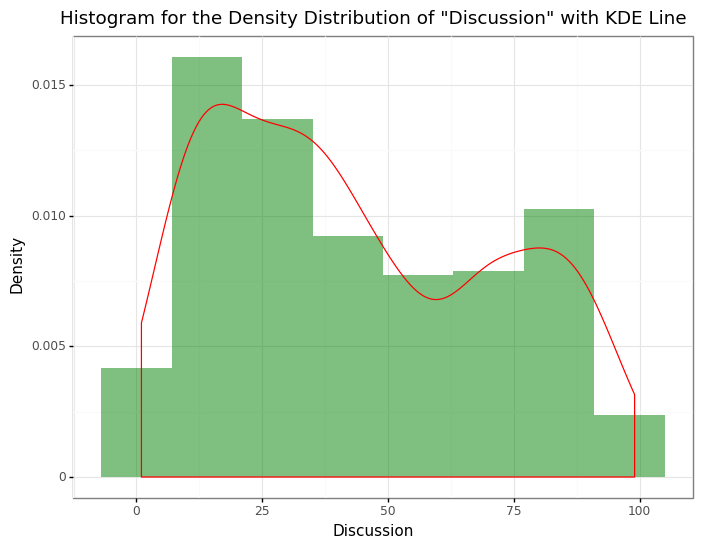

<ggplot: (306411617)>

In [23]:
make_hist("Discussion", df_final)

Histograms of our continuous variables show that there are **no significant outliers across all of our continuous variables (`raisedhands`, `VisITedResources`, `AnnouncementsView`, `Discussion`)**. Also, the KDE estimation lines suggest that it is likely that our sample data comes from **bimodal (two local peaks/modes) population distributions**.
- One possibility: three y-variable (`Class`) categories, thus two different thresholds and bimodal population distributions
- Another possibility: the existence of a group of *engaged* students versus that of *disengaged* students

In [24]:
for cate_var in cate_var_ls:
    # make and save the pie charts as image files
    plot_pie(cate_var, df_final).savefig("pie_charts/p_chart_{}.png".format(cate_var))
plt.clf() # clear the figure window after the last plot+save

<Figure size 432x288 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

Our "y-variable" (explained variable) would be `Class`, which is a **categorical (thus discrete and non-continuous) variable** that consists of three classification categories: 
1. Low-Level (`L`): interval includes values from 0 to 69,
2. Middle-Level (`M`): interval includes values from 70 to 89,
3. High-Level (`H`): interval includes values from 90-100. <br>(See the "Description" section of the dataset for more details)

Our explained variable, `Class`, appears not too unbalanced. We will of course upsample both the `L` and `H` categories to make all categories balanced (where `M` is the target)

<Figure size 432x288 with 0 Axes>

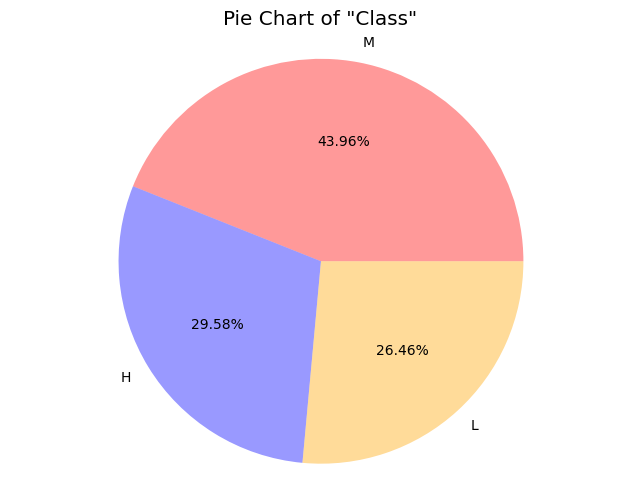

In [25]:
plot_pie("Class", df_final);

In [26]:
df_final['Class'].value_counts()

M    211
H    142
L    127
Name: Class, dtype: int64

In [27]:
# firstly, split the three groups 
df_L = df_final[df_final['Class'] == 'L'] # L group
df_M = df_final[df_final['Class'] == 'M'] # M group
df_H = df_final[df_final['Class'] == 'H'] # H group

# upsample the `L` categories
df_L_up = resample(df_L,
                   replace = True, # sample with replacement (we allow the repetition of row multiple times)
                   n_samples = 211, # target size = size of M
                   random_state = 0) # set random seed, for replicability 

# upsample the `H` categories
df_H_up = resample(df_H,
                   replace = True, # sample with replacement (we allow the repetition of row multiple times)
                   n_samples = 211, # target size = size of M
                   random_state = 0) # set random seed, for replicability 

df_final_bal = pd.concat([df_M, df_L_up, df_H_up]) # create balanced df

In [28]:
df_final_bal['Class'].value_counts()

M    211
H    211
L    211
Name: Class, dtype: int64

In [29]:
# re-order the categories: 
# from H to M to L
df_final['Class'] = pd.Categorical(df_final['Class'],
                                   categories = ["H", "M", "L"],
                                   ordered = True)

### Correlation Heat Map for All Numeric Variables

In [30]:
df_final_bal.corr()

,raisedhands,VisITedResources,AnnouncementsView,Discussion
raisedhands,1.000000,0.733199,0.684353,0.389690
VisITedResources,0.733199,1.000000,0.641400,0.301549
AnnouncementsView,0.684353,0.641400,1.000000,0.448661
Discussion,0.389690,0.301549,0.448661,1.000000


In [31]:
nested_list = [] # nested list

num_var = ["raisedhands", "VisITedResources", "AnnouncementsView", "Discussion"]

for row_var in num_var:
    for col_var in num_var:
        # each row entry to the new df: var_1, var_2, their correlation coefficient
        nested_list.append([row_var, col_var, df_final_bal.corr().loc[row_var, col_var]])

corr_df = pd.DataFrame(data = nested_list,
                       columns = ["Var_1", "Var_2", "Corr_Coeff"])

corr_df

,Var_1,Var_2,Corr_Coeff
0,raisedhands,raisedhands,1.000000
1,raisedhands,VisITedResources,0.733199
2,raisedhands,AnnouncementsView,0.684353
3,raisedhands,Discussion,0.389690
4,VisITedResources,raisedhands,0.733199
5,VisITedResources,VisITedResources,1.000000
6,VisITedResources,AnnouncementsView,0.641400
7,VisITedResources,Discussion,0.301549
8,AnnouncementsView,raisedhands,0.684353
9,AnnouncementsView,VisITedResources,0.641400


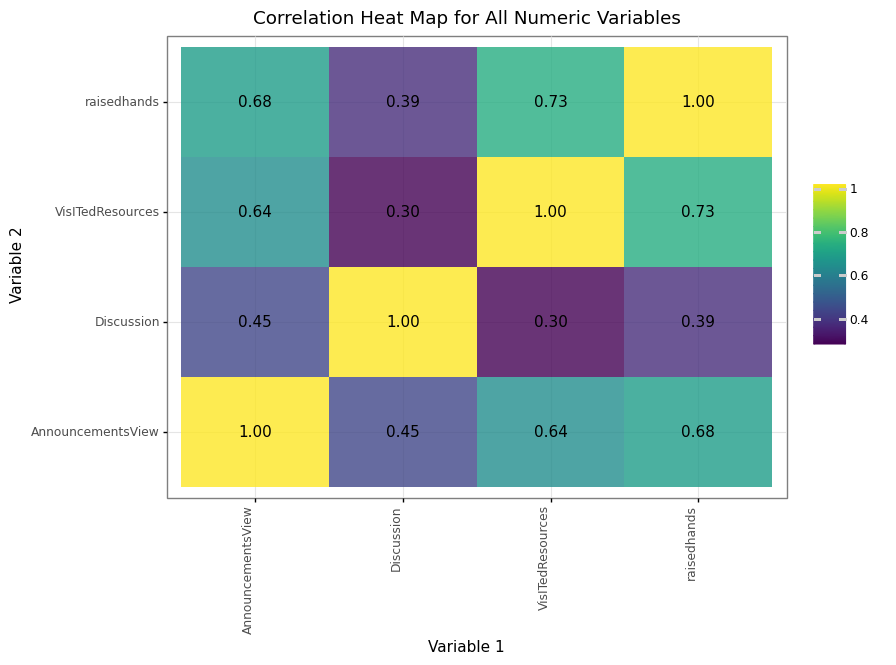

<ggplot: (306274395)>

In [32]:
(ggplot(data = corr_df, 
        mapping = aes(x = "Var_1",
                      y = "Var_2",
                      fill = "Corr_Coeff"))
 + geom_tile(alpha = 0.8) # some more transparency
 + geom_text(aes(x = "Var_1",
                 y = "Var_2",
                 label = "Corr_Coeff"), # label the correlation coefficient
             format_string = "{:.2f}") # format string to limit number of decimals
 + ggtitle("Correlation Heat Map for All Numeric Variables")
 + xlab("Variable 1")
 + ylab("Variable 2")
 + theme_bw()
 + theme(
     axis_text_x = element_text(rotation=90, hjust=1),
     legend_title = element_blank()
 )
)

### Further explorations we want to embark upon:
Finding the average “engaged” student versus the average “disengaged” student based on the bimodal distributions we discovered in our histograms.

In [33]:
df_final.median(numeric_only = True) # median - the average individual

raisedhands          50.0
VisITedResources     65.0
AnnouncementsView    33.0
Discussion           39.0
dtype: float64

In [34]:
df_final.mean(numeric_only = True) # mean - the average individual

raisedhands          46.775000
VisITedResources     54.797917
AnnouncementsView    37.918750
Discussion           43.283333
dtype: float64

### Graphic Illustrations
Stacked bar graphs by one categorical variable, fill with different performance levels (`Class`):

We also found a large gender split in the data: girls are severely under-represented in the elementary and middle school levels.

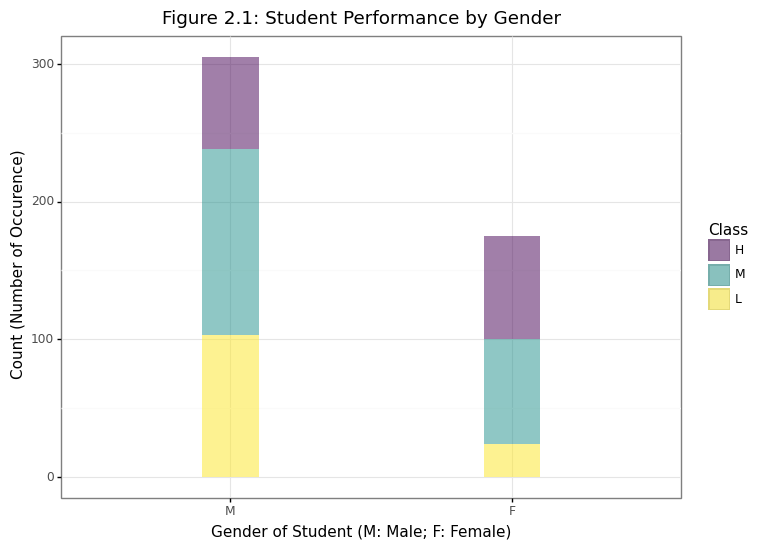

<ggplot: (274945353)>

In [35]:
(ggplot(df_final, aes(x = 'gender', fill = 'Class')) 
 + geom_histogram(binwidth = 0.2, alpha = 0.5)
 + labs(y = 'Count (Number of Occurence)',
        x = 'Gender of Student (M: Male; F: Female)')
 + ggtitle('Figure 2.1: Student Performance by Gender')
 + theme_bw())

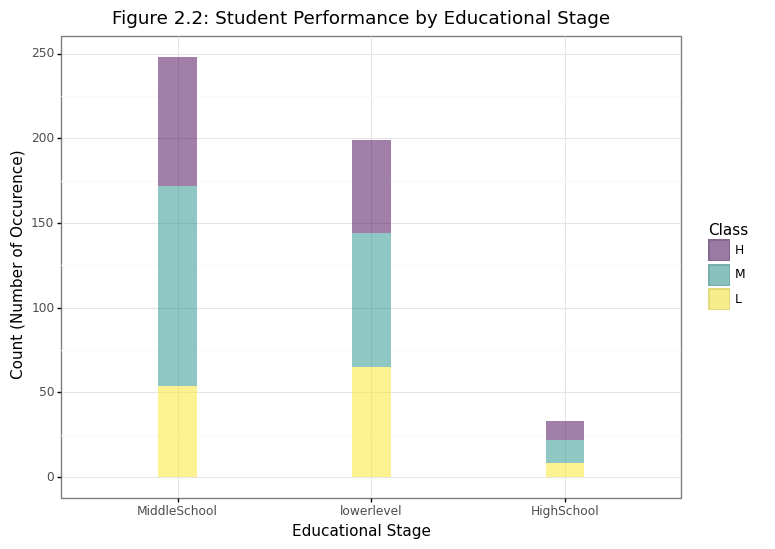

<ggplot: (273980814)>

In [36]:
(ggplot(df_final, aes(x = 'StageID', fill = 'Class')) 
 + geom_histogram(binwidth = 0.2, alpha = 0.5)
 + labs(y = 'Count (Number of Occurence)',
        x = 'Educational Stage')
 + ggtitle('Figure 2.2: Student Performance by Educational Stage')
 + theme_bw())

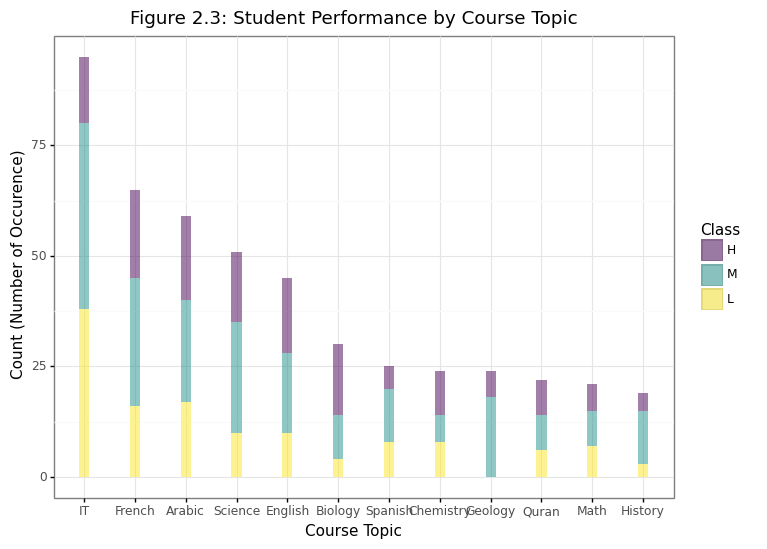

<ggplot: (274950738)>

In [37]:
(ggplot(df_final, aes(x = 'Topic', fill = 'Class')) 
 + geom_histogram(binwidth = 0.2, alpha = 0.5)
 + labs(y = 'Count (Number of Occurence)',
        x = 'Course Topic')
 + ggtitle('Figure 2.3: Student Performance by Course Topic')
 + theme_bw())

What if, for the `Student Performance by Course Topic` graph, instead of the count or frequency histogram, we want to display the **percentage of each of the performance (`Class`) categories per course topic**? Let us begin our experimentations:

In [38]:
df_by_topic_class = pd.DataFrame(df_final.groupby(['Topic'])['Class'].value_counts())
df_by_topic_class['class_percent'] = \
df_by_topic_class.groupby(level = 0).transform(lambda x: (x * 100 / x.sum()).round(2))
df_by_topic_class

Class  class_percent
Topic                            
IT        M     42          44.21
          L     38          40.00
          H     15          15.79
French    M     29          44.62
          H     20          30.77
          L     16          24.62
Arabic    M     23          38.98
          H     19          32.20
          L     17          28.81
Science   M     25          49.02
          H     16          31.37
          L     10          19.61
English   M     18          40.00
          H     17          37.78
          L     10          22.22
Biology   H     16          53.33
          M     10          33.33
          L      4          13.33
Spanish   M     12          48.00
          L      8          32.00
          H      5          20.00
Chemistry H     10          41.67
          L      8          33.33
          M      6          25.00
Geology   M     18          75.00
          H      6          25.00
          L      0           0.00
Quran     H      8          36.36
          M      8          36.36
          L      6          27.27
Math      M      8          38.10
          L      7          33.33
          H      6          28.57
History   M     12          63.16
          H      4          21.05
          L      3          15.79

In [39]:
df_by_topic_class.unstack(level=1).sort_values(by = [('class_percent', 'H')], ascending = False).reset_index()

Topic Class         class_percent              
                  H   M   L             H      M      L
0     Biology    16  10   4         53.33  33.33  13.33
1   Chemistry    10   6   8         41.67  25.00  33.33
2     English    17  18  10         37.78  40.00  22.22
3       Quran     8   8   6         36.36  36.36  27.27
4      Arabic    19  23  17         32.20  38.98  28.81
5     Science    16  25  10         31.37  49.02  19.61
6      French    20  29  16         30.77  44.62  24.62
7        Math     6   8   7         28.57  38.10  33.33
8     Geology     6  18   0         25.00  75.00   0.00
9     History     4  12   3         21.05  63.16  15.79
10    Spanish     5  12   8         20.00  48.00  32.00
11         IT    15  42  38         15.79  44.21  40.00

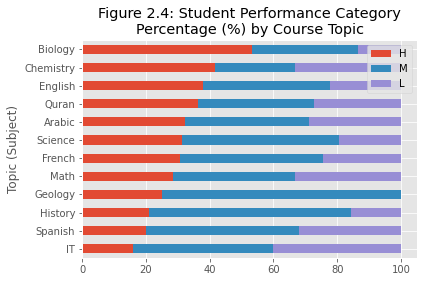

In [40]:
df_by_topic_class.unstack(level = 1).sort_values(by = [('class_percent', 'H'), ('class_percent', 'M')], \
ascending = True).reset_index().plot(
x = 'Topic',
y = 'class_percent',
kind = 'barh',
fill = 'level_1',
stacked = True,
xlabel = "Topic (Subject)",
ylabel = "Percentage (%)",
title = "Figure 2.4: Student Performance Category\nPercentage (%) by Course Topic"
);

Well, that is a new genre of percentage-based stacked bar graphs! Let us make some more graphic illustrations:

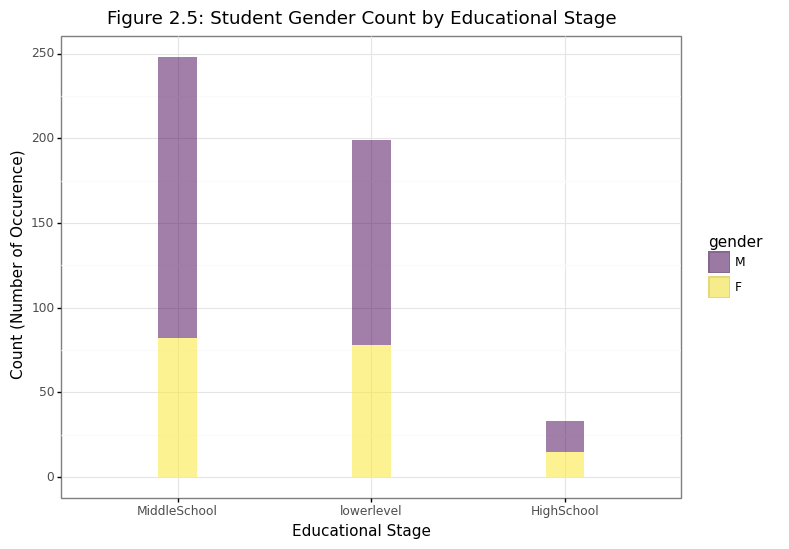

<ggplot: (307894541)>

In [41]:
(ggplot(df_final, aes(x = 'StageID', fill = 'gender')) 
 + geom_histogram(binwidth = 0.2, alpha = 0.5)
 + labs(y = 'Count (Number of Occurence)',
        x = 'Educational Stage')
 + ggtitle('Figure 2.5: Student Gender Count by Educational Stage')
 + theme_bw())

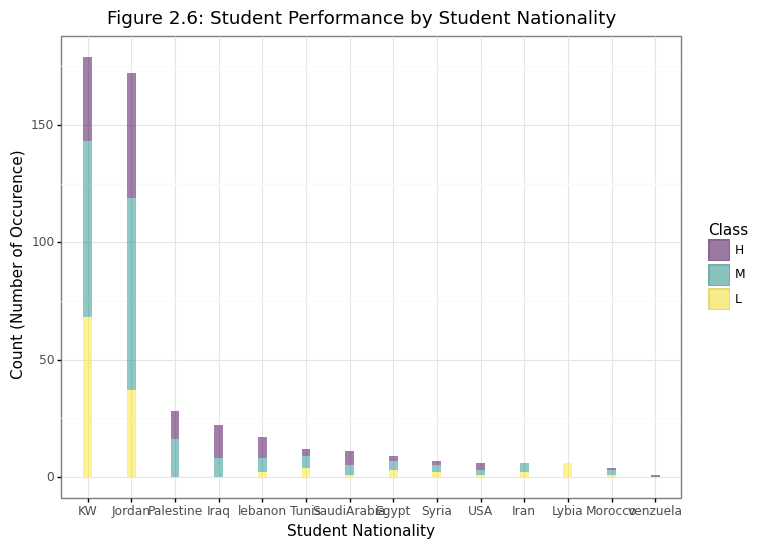

<ggplot: (307886632)>

In [42]:
(ggplot(df_final, aes(x = 'NationalITy', fill = 'Class')) 
 + geom_histogram(binwidth = 0.2, alpha = 0.5)
 + labs(y = 'Count (Number of Occurence)',
        x = 'Student Nationality')
 + ggtitle('Figure 2.6: Student Performance by Student Nationality')
 + theme_bw())

Let us also make stacked bar graph of the percentage of each of the performance (`Class`) categories by student nationality below:

In [43]:
df_by_nation_class = pd.DataFrame(df_final.groupby(['NationalITy'])['Class'].value_counts())
df_by_nation_class['class_percent'] = \
df_by_nation_class.groupby(level = 0).transform(lambda x: (x * 100 / x.sum()).round(2))
df_by_nation_class

Class  class_percent
NationalITy                        
KW          M     75          41.90
            L     68          37.99
            H     36          20.11
Jordan      M     82          47.67
            H     53          30.81
            L     37          21.51
Palestine   M     16          57.14
            H     12          42.86
            L      0           0.00
Iraq        H     14          63.64
            M      8          36.36
            L      0           0.00
lebanon     H      9          52.94
            M      6          35.29
            L      2          11.76
Tunis       M      5          41.67
            L      4          33.33
            H      3          25.00
SaudiArabia H      6          54.55
            M      4          36.36
            L      1           9.09
Egypt       M      4          44.44
            L      3          33.33
            H      2          22.22
Syria       M      3          42.86
            H      2          28.57
            L      2          28.57
USA         H      3          50.00
            M      2          33.33
            L      1          16.67
Iran        M      4          66.67
            L      2          33.33
            H      0           0.00
Lybia       L      6         100.00
            H      0           0.00
            M      0           0.00
Morocco     M      2          50.00
            H      1          25.00
            L      1          25.00
venzuela    H      1         100.00
            M      0           0.00
            L      0           0.00

In [44]:
df_by_nation_class.unstack(level=1).sort_values(by = [('class_percent', 'H')], ascending = False).reset_index()

NationalITy Class         class_percent               
                    H   M   L             H      M       L
0      venzuela     1   0   0        100.00   0.00    0.00
1          Iraq    14   8   0         63.64  36.36    0.00
2   SaudiArabia     6   4   1         54.55  36.36    9.09
3       lebanon     9   6   2         52.94  35.29   11.76
4           USA     3   2   1         50.00  33.33   16.67
5     Palestine    12  16   0         42.86  57.14    0.00
6        Jordan    53  82  37         30.81  47.67   21.51
7         Syria     2   3   2         28.57  42.86   28.57
8         Tunis     3   5   4         25.00  41.67   33.33
9       Morocco     1   2   1         25.00  50.00   25.00
10        Egypt     2   4   3         22.22  44.44   33.33
11           KW    36  75  68         20.11  41.90   37.99
12         Iran     0   4   2          0.00  66.67   33.33
13        Lybia     0   0   6          0.00   0.00  100.00

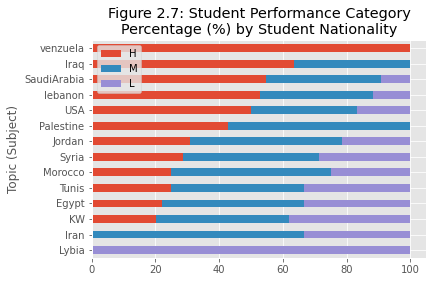

In [45]:
df_by_nation_class.unstack(level = 1).sort_values(by = [('class_percent', 'H'), ('class_percent', 'M')], \
ascending = True).reset_index().plot(
x = 'NationalITy',
y = 'class_percent',
kind = 'barh',
fill = 'level_1',
stacked = True,
xlabel = "Topic (Subject)",
ylabel = "Percentage (%)",
title = "Figure 2.7: Student Performance Category\nPercentage (%) by Student Nationality"
);

### 2.3: Possible Limitations and Ways to Mitigate Them
Addressing **sub-question 4**:
- What possible limitations do you expect to face, and how would you justify them?

1. The first possible limitation is that our data is **observational** and therefore subject to issues such as **spurious correlations, confusion between cause and effect (the existence of confounding variables or omitted variables that cannot be measured/included), and/or multicollinearity**. 
    - We will try to use regression discontinuity to address confusion between cause and effect.
    - We assume that multicollinearity is not perfect (so, for instance, the OLS estimators can still be estimated, only with higher standard errors) and therefore not a major cause of concern.
    - And we will be careful in differentiating between correlation and cause and effect when drawing conclusions based on our data.


2. In addition, we do not know about many **outside factors (exogenous to our proposed models) that might affect our data**—such as if some of the schools included in the data are boys-only schools (which would affect our inquiries on gender) or whether students are given a participation grade in class which could incentivize participation among students who are not actually engaged.


3. Also, one student may be taking many classes which could introduce **interdependence among the observations** (violating the *independent and identically distributed* and thus *spherical error terms* assumption of the Gauss-Markov Assumptions). To protect the anonymity of student data, we cannot see if the same student is taking multiple classes. To minimize the effect of this, we will avoid using OLS (which may possibly no longer be the BLUE (Best Linear Unbiased Estimator)) and instead use regression discontinuity. 
    - *Comment: We looked at the discussion of the dataset on Kaggle and found the claim that each entry corresponds to only one individual student, the assumption of which would mitigate this issue.
